In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(rasqualTools))
suppressPackageStartupMessages(library(stringr))
suppressPackageStartupMessages(library(parallel))

In [1]:
# Colnames for rasqual outputs
coln = c('Feature','rsID','Chromosome','position','Ref' ,'Alt' ,'Af','HWEChi_square' ,'IA','Log10_qval','Chi_square',
        'Effect_size','Sequencing_mapping_error_rate','Ref_allele_bias' ,'Overdispersion','SNPid_within_region',
        'No_fSNPs','No_tested_SNPs','No_iterations_for_H0','No_iterations_for_H1',"ties",'Log_likelihood_H0',
        'Convergence_status','r2_fSNPs','r2_rSNP')

In [3]:
# Function to run rasqual

rasqual_caQTL = function(x, snp_counts, counts, offsets, covariates,  vcf=vcf_file, outdir, 
                         nsamples=10, lead=TRUE, permut=FALSE) 
{
region  = paste0(snp_counts$chromosome_name[x], ":",snp_counts$range_start[x] ,"-",snp_counts$range_end[x])
outfile = paste0(outdir, "/",  snp_counts$gene_id[x])   
    
#system(paste("tabix",  vcf, region, "| $RASQUALDIR/bin/rasqual", # This probably will work once I restart jupyter
console_out <- system(paste("tabix",  vcf, region, "| /home/welison/rasqual/rasqual-master/bin/rasqual", 
'-y', counts,
'-k', offsets,
'-x', covariates,
"-n", nsamples,             
'-j', indexes[x] ,
'-l', snp_counts$cis_snp_count[x] ,
'-m', snp_counts$feature_snp_count[x] , 
'-s', snp_counts$exon_starts[x],
'-e', snp_counts$exon_ends[x] , 
'-f', snp_counts$gene_id[x],
 c("","-t" )  [(lead==TRUE) +1]   ,
 c("","-r" )  [(permut==TRUE) +1]   ,
 '--minor-allele-frequency 0.051 --minor-allele-frequency-fsnp 0.051' ,
 '--force',
#'--min-coverage-depth 6',
'>', outfile), intern=TRUE)
    
    #print(console_out)
    
}

In [4]:
#options(repr.plot.width=12, repr.plot.height=2)
#pdf("/nfs/lab/welison/islet_multiome/intermediates/caQTLs/221202_WE_caQTLs/figures/scheme.pdf")
#par(mfrow=c(1,2), mar=c(4,1,1,4))
#
## plot(x=c(-100,200, 8000,-5500, -5000 ), y=rep(0.4, 5) , ylim = 0:1,  xlim=c(-1e4, 1e4),   axes=F, pch="|", xlab="bp", main="run1")
## points(x=c(-5000, 0, 8000), y=rep(0.1, 3)   , pch=17, col=c(4,2,4), cex=3)
## axis(1)
#plot(x=c(-100,200, 8000,-5500, -5000 ,sample(-1e4:1e4, 20, replace=FALSE )), y=rep(0.4, 25) , ylim = 0:1,  xlim=c(-1e4, 1e4),   axes=F, pch="|", xlab="bp", main="run3")
#points(x=c(-5000, 0, 8000), y=rep(0.1, 3)   , pch=17, col=c(4,2,4), cex=3)
#axis(1)
## plot(x=c(-100,200, sample(-5e4:5e4, 50, replace=FALSE)  ), y=rep(0.4, 52) , ylim = 0:1,  xlim=c(-5e4, 5e4),   axes=F, pch="|", xlab="bp", main="run2")
## points(x=c(-40000, -10000, 0, 8000), y=rep(0.1, 4)   , pch=17, col=c(4,4,2,4), cex=3)
## axis(1,at = c(-50000, -25000, 0,25000,50000  ))
#dev.off()

png 
  2

In [3]:
###### set parmetes here ######
maindir     = '/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/caQTLs_rasqual/'
matdir      = '/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/atac_cell_type_matrices/'
#celltypes = c('alpha')
#celltypes = c('beta','acinar')
celltypes =  c('bulk','delta','ductal','endothelial','gamma','immune','stellate')
#celltypes =  c('bulk','acinar','alpha','beta','delta','ductal','endothelial','gamma',
#               'immune','stellate') #Add subtypes later
#nsamples    = 27
vcfdirname  = 'vcfs_peaks100kb' #'vcfs_peaksonly'
ciswindow   =  10000            #10000
runname     = "run1"            # run1
npermut     = 2
####################################

setwd(maindir)

In [8]:
#for (c in celltypes){
#for (c in c('bulk','delta','ductal','endothelial','gamma','immune','stellate')) {
for (c in c('beta')) {
    #Load in inputs and count snps to test
    cat (c, "\n")
    counts      = paste0( matdir, "/counts.",c, ".bin" )
    offsets     = paste0( matdir, "/size_factors.",c, ".bin" )
    covariates  = paste0( matdir, "/covariates_full.",c, ".bin" ) #/covariates2.
    
    inp = read.table(paste0( matdir, "/counts.",c, ".txt" ), row.names=1)
    cm  = read.table(paste0( matdir,c, ".count_matrix" ), header=T, stringsAsFactors = F)
    
    samples  = read.table(paste0(matdir, "samples.",c, ".csv"), sep=',')[[1]]
    nsamples = length(samples)
    
    peak_data = cm[,c(1,2,5,3,4)]
    peak_data$Strand = as.integer(1)
    colnames(peak_data) =  c('gene_id','chr','strand','exon_starts','exon_ends')
    peak_data$exon_starts = as.character(peak_data$exon_starts)
    peak_data$exon_ends = as.character(peak_data$exon_ends)
    
    vcf_dir = paste0(c, "/",vcfdirname, "/")
    outdir <- paste0(c, '/', runname, "/")
    system(paste0('mkdir ', outdir))
    
    for (n in 22) {
        #Identify SNPs to test
        vcf_file = paste0(vcf_dir,  'chr', n, '.ase.nofilt.vcf.gz' )
        
        system(paste0("bcftools query -f '%CHROM\\t%POS\\t%ID\\n' ", 
                        vcf_file,  " > ",  vcf_dir, 'chr', n,'.ase.filt.snps'))
           
        snps2           = read.table(paste0(vcf_dir, "chr", n,".ase.filt.snps"))
        colnames(snps2) = c('chr','pos','snp_id')
            
        snp_counts2 = countSnpsOverlapingExons(peak_data, snps2, cis_window = ciswindow)
        snp_counts2 = subset(snp_counts2, feature_snp_count>0 |  cis_snp_count> 0)
        snp_counts_sub = subset(snp_counts2, gene_id %in% rownames(inp))
        
        indexes =  match ( snp_counts_sub$gene_id,rownames(inp))
        snp_counts_use = snp_counts_sub
            
        write.table(snp_counts_use, paste0(outdir, 'chr',n,".",runname,'.snp_counts_use.tsv'), quote = FALSE, sep = "\t",
               col.names=TRUE, row.names=FALSE)
            
        cat(sum(rownames(inp[indexes,])!= snp_counts_sub$gene_id), "\n")
        
        #### Run real rasqual run
        
        ####################
        P           =  FALSE ## permutation?  
        folder_name =  paste0(runname, '_all')
        L           =  FALSE ## report only lead?
        ####################
          
        outdir_sub = paste0( outdir, folder_name , "/",paste0("chr", n))
        system(paste('mkdir -p', outdir_sub))
        
        #print(head(snp_counts_use))
        #print(vcf_file)
        #print(outdir)
          
        mclapply(1:nrow(snp_counts_use), function(x) rasqual_caQTL(x, snp_counts_use, counts, offsets, covariates, 
            nsamples=nsamples, vcf=vcf_file, outdir=outdir_sub,  lead=L, permut=P) , mc.cores = 24 ) 
                 
        ## permutations ####################         
        if( npermut >0) {  
            for(np in 1:npermut ){
                P           =  TRUE  
                folder_name =  paste0(runname, '_perm', np, "_lead")
                L           =  TRUE
                
                outdir_sub = paste( outdir, folder_name , paste0("chr", n), sep ="/")
                system(paste('mkdir -p', outdir_sub))
      
                mclapply(1:nrow(snp_counts_use), function(x) rasqual_caQTL(x, snp_counts_use, counts, offsets, covariates, 
                                                           nsamples=nsamples, 
                                                           vcf=vcf_file, outdir=outdir_sub, 
                                                           lead=L, permut=P) , mc.cores = 24 )
             }### end permutations  
        } ## end chromosomes
    } ### end celltypes
}

beta 
0 
[1] "chr1:100026776-100047124"
[1] "beta/run1/run1_all/chr1/chr1:100036775-100037124"
[1] "beta/vcfs_peaks100kb/chr1.ase.nofilt.vcf.gz"
[1] "/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/atac_cell_type_matrices//counts.beta.bin"
[1] "/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/atac_cell_type_matrices//size_factors.beta.bin"
[1] "/nfs/lab/welison/islet_multiome/intermediates/caQTLs/231026_WE_caQTLs/atac_cell_type_matrices//covariates_full.beta.bin"
[1] 10734
[1] 89
[1] 0
[1] "100036776"
[1] "100037124"
[1] "chr1:100036775-100037124"


In [14]:
celltypes =  c('bulk','acinar','alpha','beta','delta','ductal','endothelial','gamma',
               'immune','stellate') #Add subtypes later
celltypes

[1] "bulk"        "acinar"      "alpha"       "beta"        "delta"      
 [6] "ductal"      "endothelial" "gamma"       "immune"      "stellate"

Results are saved by chromosome/feature so concatenate into one file  
SKIPPED are features skipped, usually due to too many SNPs to test. The force paramater makes this happen.

In [38]:
compile_results = function(n,runname, folder_name, c ){
    chrom  = paste0("chr", n)
    outdir = paste( c, runname,folder_name , chrom, sep ="/")
    system(paste0("cat ", outdir,  "/* > ", outdir,'/',folder_name,".results_chr", n))
}


for (c in celltypes){
    cat (c, "\n")
    for (folder_name in paste0(runname, c("_all", '_perm1_lead', '_perm2_lead'))){
   
        tabname = paste0(c, '/',runname,"/Results_", folder_name, ".tsv")
        
        mclapply (1:22, function(x) compile_results(n=x,runname=runname, folder_name=folder_name, c=c), mc.cores=22)
         
        system(paste0("cat ", c , "/", runname, '/',folder_name,'/chr*/',folder_name,".results_chr* > ", tabname))
        results = read.table(tabname, fill=T)
        colnames(results) = coln
        skipped = subset(results,results$rsID =="SKIPPED")
        results = subset(results,results$rsID !="SKIPPED")
        results$P_VAl = pchisq(results[,11], 1, lower=F)
        write.table(results, tabname, sep="\t", quote=F)
        write.table(skipped, paste0(c, '/', runname, "/Results_", folder_name, ".SKIPPED.tsv"), sep="\t", quote=F)
    }
}

bulk 
acinar 
alpha 
beta 
delta 
ductal 
endothelial 
gamma 
immune 
stellate 


In [39]:
celltypes

[1] "bulk"        "acinar"      "alpha"       "beta"        "delta"      
 [6] "ductal"      "endothelial" "gamma"       "immune"      "stellate"

### Calculate q value from null  
From Paola

In [40]:
# q1 : real lead Q-value vector for all peaks from RASQUAL
# q0 : permutated Q-value vector
# alpha : FDR threshold
# This function returns the P-value threshold corresponding to FDR=alpha.
getFDR <-
function(q1, q0, alpha=0.1, z=NULL, subset=NULL){
	if(is.null(z)){
		a=0
		for(itr in 1:10){
			a=getFDR(q1,q0,alpha,rev(a+0:100/100^itr),subset)
		}
		a
	}else{
		if(!is.null(subset)){
			q1=q1[subset]
			q0=q0[subset]
		}
		q1=q1[!is.na(q1)]
		q0=q0[!is.na(q0)]
		x=NULL;
		for(i in z){
			x=c(x,sum(q0<i)/length(q0)/(sum(q1<i)/length(q1)))
		};
		max(c(0,z[x<alpha]),na.rm=T)
	}
}


In [41]:
celltypes

[1] "bulk"        "acinar"      "alpha"       "beta"        "delta"      
 [6] "ductal"      "endothelial" "gamma"       "immune"      "stellate"

In [42]:
celltypes_reorder <- celltypes
celltypes_reorder

[1] "bulk"        "acinar"      "alpha"       "beta"        "delta"      
 [6] "ductal"      "endothelial" "gamma"       "immune"      "stellate"

In [43]:
df_all = data.frame()
df = data.frame()
#for (c in celltypes) {
for (c in celltypes_reorder) {
    results       = read.table(paste0(c, '/',runname,"/Results_", runname, "_all.tsv"), header=T, stringsAsFactors = F)
    #random        = read.table(paste0(c, "/Results_run4_perm1_lead.tsv"), header=T, stringsAsFactors = F)
    #random2       = read.table(paste0(c, "/Results_run4_perm2_lead.tsv"), header=T, stringsAsFactors = F)
    random = c()
    for (i in 1:2){
        random =c(random,
        read.table(paste0(c, '/',runname, sprintf(paste0("/Results_", runname, "_perm%s_lead.tsv"),i)), header=T, stringsAsFactors = F)$Log10_qval)
    }
    
    bed = str_split_fixed(results$Feature, ":|-", 3)

    mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)
    results$dist <- results$position - round(mid)
    
    results       = results[order(abs(results$dist)),]
    results       = results[order(results$P_VAl),]
    results_lead  = results[!duplicated(results$Feature),]
    
    # thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.1) 
    # thresh05       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.05) 
    # thresh01       = getFDR(10^(results_lead$Log10_qval), 10^(c(random$Log10_qval,random2$Log10_qval )), 0.01) 

    thresh10      = getFDR(10^(results_lead$Log10_qval), 10^(random), 0.1) 
    thresh05       = getFDR(10^(results_lead$Log10_qval), 10^(random), 0.05) 
    thresh01       = getFDR(10^(results_lead$Log10_qval), 10^(random), 0.01) 

    results$flag_fdr10 = 10^(results$Log10_qval) < thresh10
    results$flag_fdr05 = 10^(results$Log10_qval) < thresh05
    results$flag_fdr01 = 10^(results$Log10_qval) < thresh01
              
    results_lead$flag_fdr10 = 10^(results_lead$Log10_qval) < thresh10
    results_lead$flag_fdr05 = 10^(results_lead$Log10_qval) < thresh05
    results_lead$flag_fdr01 = 10^(results_lead$Log10_qval) < thresh01
    df = rbind(df, c(thresh10, sum(results_lead$flag_fdr10, na.rm=T) , 
                   thresh05, sum(results_lead$flag_fdr05, na.rm=T),
                   thresh01, sum(results_lead$flag_fdr01, na.rm=T), nrow(results_lead)))
    
    df_all = rbind(df_all, c(thresh10, sum(results$flag_fdr10, na.rm=T) , 
                       thresh05, sum(results$flag_fdr05, na.rm=T),
                       thresh01, sum(results$flag_fdr01, na.rm=T), nrow(results)))

    write.table(results_lead, paste0(c, '/',runname, "/Results_", runname, "_lead.tsv"),sep="\t", quote=F, row.names=F)
    write.table(results, paste0(c, '/',runname, "/Results_",runname,"_all.tsv"),sep="\t", quote=F, row.names=F)  
}
rownames(df) = celltypes_reorder
colnames(df) = c('qval_fdr10%', 'caQTL_fdr10%', 'qval_fdr05%', 'caQTL_fdr05%','qval_fdr01%', 'caQTL_fdr01%', "tested_features")

rownames(df_all) = celltypes
colnames(df_all) = c('qval_fdr10%', 'caQTL_fdr10%', 'qval_fdr05%', 'caQTL_fdr05%','qval_fdr01%', 'caQTL_fdr01%', "tested_features")

In [44]:
df #run1
df_all #run1

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,0.041159926,16045,0.016394056,12232,0.001560898,7458,254796
acinar,0.028043687,3163,0.009841994,2225,0.000325682,1031,112508
alpha,0.044739913,6688,0.019261193,4954,0.002991037,2958,191787
beta,0.043914046,9734,0.017379103,7205,0.001816696,4302,228634
delta,0.067062466,1282,0.032989093,882,0.008623231,504,86691
ductal,0.037689747,422,0.013799452,268,0.001464991,107,49872
endothelial,0.000000000,0,0.000000000,0,0.000000000,0,1399
gamma,0.064835169,763,0.034222542,528,0.007940879,276,62514
immune,0.039476476,9,0.020176438,4,0.020176438,4,8174


,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,0.041159926,440470,0.016394056,327860,0.001560898,187906,11650033
acinar,0.028043687,88076,0.009841994,60279,0.000325682,26618,5114968
alpha,0.044739913,183694,0.019261193,132169,0.002991037,76145,8655428
beta,0.043914046,265993,0.017379103,192345,0.001816696,108548,10394491
delta,0.067062466,37360,0.032989093,25759,0.008623231,14342,3856004
ductal,0.037689747,12938,0.013799452,8485,0.001464991,3531,2267375
endothelial,0.000000000,0,0.000000000,0,0.000000000,0,54249
gamma,0.064835169,23102,0.034222542,15570,0.007940879,7967,2761532
immune,0.039476476,244,0.020176438,130,0.020176438,130,324788


In [17]:
#df #run12
#df_all #run12

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,4.098030e-02,15445,1.818177e-02,11803,2.393838e-03,7102,254775
acinar,2.782302e-02,3713,1.063253e-02,2625,7.492662e-04,1368,112499
alpha,3.869662e-02,8035,1.581534e-02,5891,2.078343e-03,3484,191772
beta,4.028894e-02,11266,1.633177e-02,8454,2.212967e-03,5328,228614
delta,3.866911e-02,1778,1.635266e-02,1212,3.381147e-03,694,84877
ductal,3.555685e-02,551,1.706661e-02,411,1.989931e-03,179,48778
endothelial,0.000000e+00,0,0.000000e+00,0,0.000000e+00,0,1399
gamma,4.364447e-02,991,2.306949e-02,709,4.873922e-03,369,61039
immune,6.317142e-03,1,6.317142e-03,1,6.317142e-03,1,7590


,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,4.098030e-02,396439,1.818177e-02,294158,2.393838e-03,165556,11529978
acinar,2.782302e-02,98844,1.063253e-02,68886,7.492662e-04,34031,5060372
alpha,3.869662e-02,206854,1.581534e-02,146305,2.078343e-03,81733,8565809
beta,4.028894e-02,293385,1.633177e-02,215091,2.212967e-03,128025,10286693
delta,3.866911e-02,45592,1.635266e-02,30479,3.381147e-03,17147,3780169
ductal,3.555685e-02,15429,1.706661e-02,11321,1.989931e-03,4710,2214694
endothelial,0.000000e+00,0,0.000000e+00,0,0.000000e+00,0,53551
gamma,4.364447e-02,26135,2.306949e-02,18486,4.873922e-03,9481,2694191
immune,6.317142e-03,24,6.317142e-03,24,6.317142e-03,24,303403


In [36]:
#df #run11
#df_all #run11

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,0.031855967,15668,0.013229178,11893,0.0012641416,6869,254745
acinar,0.016098176,3814,0.005930486,2794,0.0005479569,1572,110484
alpha,0.032299322,8392,0.014340509,6313,0.0021434785,3875,189484
beta,0.025881191,11914,0.010475823,9076,0.0013779587,5762,226849
delta,0.033347999,1963,0.014490040,1384,0.0030519217,831,82914
ductal,0.038175353,643,0.015824386,434,0.0030920786,229,47572
endothelial,0.000000000,0,0.000000000,0,0.0000000000,0,1239
gamma,0.040716072,1029,0.018898627,698,0.0058930019,430,59631
immune,0.005850716,2,0.005850716,2,0.0058507159,2,7293


,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,0.031855967,394685,0.013229178,293103,0.0012641416,160133,11639834
acinar,0.016098176,95376,0.005930486,69003,0.0005479569,37649,5017304
alpha,0.032299322,209346,0.014340509,154175,0.0021434785,90065,8543048
beta,0.025881191,292228,0.010475823,218759,0.0013779587,131971,10301276
delta,0.033347999,49178,0.014490040,34116,0.0030519217,19591,3728144
ductal,0.038175353,17807,0.015824386,11905,0.0030920786,5923,2180612
endothelial,0.000000000,0,0.000000000,0,0.0000000000,0,47932
gamma,0.040716072,26487,0.018898627,17387,0.0058930019,10738,2658579
immune,0.005850716,81,0.005850716,81,0.0058507159,81,293681


In [23]:
#df #run10
#df_all #run10

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acinar,0.031659935,2473,0.013412801,1777,0.0015299663,923,114821
alpha,0.031313257,4944,0.011923947,3463,0.0013034385,1808,191318
beta,0.042995862,7954,0.017896286,5836,0.0019971652,3243,231392
delta,0.047757039,942,0.022316457,600,0.0044082471,289,81617
ductal,0.032893368,305,0.015770048,207,0.0008892251,60,43262
endothelial,0.000000000,0,0.000000000,0,0.0000000000,0,1578
gamma,0.051290337,561,0.025606447,358,0.0051055840,171,65205
immune,0.010118789,2,0.010118789,2,0.0101187891,2,7663
stellate,0.006784992,2,0.006784992,2,0.0067849918,2,11219


,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acinar,0.031659935,68367,0.013412801,48111,0.0015299663,24878,4687252
alpha,0.031313257,130480,0.011923947,89970,0.0013034385,45822,7759060
beta,0.042995862,214168,0.017896286,153499,0.0019971652,82667,9458918
delta,0.047757039,25507,0.022316457,15572,0.0044082471,7452,3298686
ductal,0.032893368,8780,0.015770048,5878,0.0008892251,1852,1777862
endothelial,0.000000000,0,0.000000000,0,0.0000000000,0,54624
gamma,0.051290337,16253,0.025606447,10142,0.0051055840,4993,2615865
bulk,0.010118789,60,0.010118789,60,0.0101187891,60,277833
immune,0.006784992,31,0.006784992,31,0.0067849918,31,418123


In [45]:
length(random) #run1

[1] 23832

In [18]:
#length(random) #run12

[1] 22286

In [37]:
#length(random) #run11

[1] 21588

In [12]:
#length(random) #run7

[1] 509296

In [16]:
#length(random) run4

[1] 509258

In [46]:
dim(results_lead)  #run1

[1] 11916    30

In [20]:
#dim(results_lead)  #run12

[1] 11143    30

In [19]:
#dim(results_lead)  #run11

In [14]:
#dim(results_lead)  #run7

[1] 254648     29

In [47]:
df #run1

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,0.041159926,16045,0.016394056,12232,0.001560898,7458,254796
acinar,0.028043687,3163,0.009841994,2225,0.000325682,1031,112508
alpha,0.044739913,6688,0.019261193,4954,0.002991037,2958,191787
beta,0.043914046,9734,0.017379103,7205,0.001816696,4302,228634
delta,0.067062466,1282,0.032989093,882,0.008623231,504,86691
ductal,0.037689747,422,0.013799452,268,0.001464991,107,49872
endothelial,0.000000000,0,0.000000000,0,0.000000000,0,1399
gamma,0.064835169,763,0.034222542,528,0.007940879,276,62514
immune,0.039476476,9,0.020176438,4,0.020176438,4,8174


In [21]:
#df #run12

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bulk,4.098030e-02,15445,1.818177e-02,11803,2.393838e-03,7102,254775
acinar,2.782302e-02,3713,1.063253e-02,2625,7.492662e-04,1368,112499
alpha,3.869662e-02,8035,1.581534e-02,5891,2.078343e-03,3484,191772
beta,4.028894e-02,11266,1.633177e-02,8454,2.212967e-03,5328,228614
delta,3.866911e-02,1778,1.635266e-02,1212,3.381147e-03,694,84877
ductal,3.555685e-02,551,1.706661e-02,411,1.989931e-03,179,48778
endothelial,0.000000e+00,0,0.000000e+00,0,0.000000e+00,0,1399
gamma,4.364447e-02,991,2.306949e-02,709,4.873922e-03,369,61039
immune,6.317142e-03,1,6.317142e-03,1,6.317142e-03,1,7590


In [15]:
#df #run7

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acinar,0.031659935,2473,0.013412801,1777,0.0015299663,923,114821
alpha,0.031313257,4944,0.011923947,3463,0.0013034385,1808,191318
beta,0.042995862,7954,0.017896286,5836,0.0019971652,3243,231392
delta,0.047757039,942,0.022316457,600,0.0044082471,289,81617
ductal,0.032893368,305,0.015770048,207,0.0008892251,60,43262
endothelial,0.000000000,0,0.000000000,0,0.0000000000,0,1578
gamma,0.051290337,561,0.025606447,358,0.0051055840,171,65205
immune,0.010118789,2,0.010118789,2,0.0101187891,2,7663
stellate,0.006784992,2,0.006784992,2,0.0067849918,2,11219


In [18]:
#df run4

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acinar,0.03043739,2438,0.01151958,1691,0.0004785115,711,114809
alpha,0.02946988,4812,0.01406307,3677,0.0013468117,1825,191305
beta,0.04084779,7770,0.01626446,5651,0.0012431216,2931,231375
delta,0.04499899,905,0.01999264,574,0.0035129575,263,81613
ductal,0.02439943,265,0.01021562,159,0.0047226246,118,43258
endothelial,0.00000000,0,0.00000000,0,0.0000000000,0,1577
gamma,0.04766716,532,0.01919980,311,0.0026629268,135,65201
immune,0.03258025,5,0.02824055,5,0.0282405468,5,7660
stellate,0.02049126,7,0.01839987,5,0.0183998705,5,11216


In [14]:
### 10 permutations (MAF>0.051)
#df

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acinar,0.03043739,2438,0.01151958,1691,0.0004785115,711,114809
alpha,0.02946988,4812,0.01406307,3677,0.0013468117,1825,191305
beta,0.04084779,7770,0.01626446,5651,0.0012431216,2931,231375
delta,0.04499899,905,0.01999264,574,0.0035129575,263,81613
ductal,0.02439943,265,0.01021562,159,0.0047226246,118,43258
endothelial,0.00000000,0,0.00000000,0,0.0000000000,0,1577
gamma,0.04766716,532,0.01919980,311,0.0026629268,135,65201
bulk,0.03943031,12901,0.01696881,9754,0.0015378367,5602,254629
immune,0.03258025,5,0.02824055,5,0.0282405468,5,7660


In [34]:
### 2 permuations (MAF>0.051)
#df

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acinar,0.03043739,2438,0.01151958,1691,0.0004785115,711,114809
alpha,0.02946988,4812,0.01406307,3677,0.0013468117,1825,191305
beta,0.04499899,905,0.01999264,574,0.0035129575,263,81613
delta,0.02439943,265,0.01021562,159,0.0047226246,118,43258
ductal,0.00000000,0,0.00000000,0,0.0000000000,0,1577
endothelial,0.04766716,532,0.01919980,311,0.0026629268,135,65201
gamma,0.03943031,12901,0.01696881,9754,0.0015378367,5602,254629
bulk,0.03258025,5,0.02824055,5,0.0282405468,5,7660
immune,0.02049126,7,0.01839987,5,0.0183998705,5,11216


In [490]:
#df paola

,qval_fdr10%,caQTL_fdr10%,qval_fdr05%,caQTL_fdr05%,qval_fdr01%,caQTL_fdr01%,tested_features
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
acinar,0.03195165,2747,0.013065342,1992,6.585380e-04,885,133283
alpha,0.03973554,5357,0.016756178,3774,2.303915e-03,2084,217326
beta,0.04679819,9423,0.020570449,7034,3.275024e-03,4223,269745
delta,0.04683101,1148,0.021046727,751,3.067506e-03,314,95607
ductal,0.03853054,566,0.012945981,311,1.907976e-03,141,57885
gamma,0.05318704,639,0.031469360,471,3.919157e-06,20,67373
bulk,0.04437036,15299,0.018655789,11501,1.642678e-03,6546,298229
acinar0,0.03383566,2503,0.010460399,1604,9.208149e-04,796,119504
acinarREGPOS,0.03432005,411,0.015557617,266,2.632380e-03,126,43417


In [48]:
write.csv(df, paste0("summary_",runname,".csv"))

In [492]:
# barcodelist = read.table( "../../data/barcode_celltypes.txt",header=T)
# celltypes1 = c('acinar','alpha','beta','delta','ductal','gamma')

# celltypes2 = c('acinar0', 'acinarREGPOS','alpha_1', "alpha_2",'beta_1','beta_2','beta_3','beta_4','beta_5','ductal0')

# barcodelist1 = subset(barcodelist, celltype.x %in% celltypes1) [,c('celltype.x','sample','barcode')]
# barcodelist2 = subset(barcodelist, celltype.y %in% celltypes2)[,c('celltype.y','sample','barcode')]

# colnames(barcodelist2)[1] = colnames(barcodelist1) [1]= "celltype"

# barcodelist = rbind(barcodelist1, barcodelist2)
# write.table(barcodelist, "../../data/barcode_celltypes_selection.txt", row.names=F, quote=F)         

In [6]:
runname <- 'run1'
c <- 'beta'

In [10]:
results_lead <- read.table(paste0(c, '/',runname, "/Results_", runname, "_lead.tsv"),sep="\t", header=T)

In [11]:
dim(results_lead)
head(results_lead)

[1] 228634     30

,Feature,rsID,Chromosome,position,Ref,Alt,Af,HWEChi_square,IA,Log10_qval,⋯,ties,Log_likelihood_H0,Convergence_status,r2_fSNPs,r2_rSNP,P_VAl,dist,flag_fdr10,flag_fdr05,flag_fdr01
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>,<lgl>,<lgl>
1,chr11:3421659-3423660,chr11:3422496:T:A,chr11,3422496,T,A,0.111111,0.421875,0.961691,-77.18683,⋯,3422496,173.76734,0,0.818913,0.944782,3.460434e-79,-164,TRUE,TRUE,TRUE
2,chr20:33105588-33106830,chr20:33106308:A:G,chr20,33106308,A,G,0.259259,0.034439,0.998589,-57.48574,⋯,33106308,129.46566,0,0.992436,0.993817,3.043698e-59,99,TRUE,TRUE,TRUE
3,chr6:32668115-32668714,chr6:32666564:A:G,chr6,32666564,A,G,0.388889,5.578512,0.999942,-56.81707,⋯,32666564,128.61093,0,0.995213,0.856132,7.157935e-59,-1850,TRUE,TRUE,TRUE
4,chr3:188351801-188352990,chr3:188352736:G:A,chr3,188352736,G,A,0.092593,0.281133,0.999396,-47.98072,⋯,188352736,105.87696,0,0.987970,0.986822,2.747480e-49,340,TRUE,TRUE,TRUE
5,chr8:17607871-17609288,chr8:17602712:A:G,chr8,17602712,A,G,0.203704,0.020395,0.999579,-44.90745,⋯,17602712,102.55801,0,0.993821,0.708275,8.476066e-48,-5868,TRUE,TRUE,TRUE
6,chr6:32622377-32623439,chr6:32624000:G:T,chr6,32624000,G,T,0.462963,1.913385,0.998700,-39.94031,⋯,32626284,93.23818,0,0.991017,0.688329,2.290107e-43,1092,TRUE,TRUE,TRUE


In [12]:
bed = str_split_fixed(results_lead$Feature, ":|-", 3)
mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)
tb = data.frame(midpoint = round(mid), snppsos = results_lead$position)
tb$dist = tb$snppsos - tb$midpoint

In [14]:
tb$dist[results_lead$flag_fdr10]

[1]   -164     99  -1850    340  -5868   1092    -27   5846  -2653  -9516
  [11]   -335   -109   -133  -5368  -2639   2631   4144   5888    553    -28
  [21]   -389     26    219   -699   -309   -155   -231   -138  -6159   -205
  [31]   7140    263    -65  -2890   -534    182   -455  -2895  -8908   -364
  [41]   -129   -155  -1662   -252   -600    -11    325  -1614   -127  -7471
  [51]    -22   -359  -1330    -94   2022    353   -417    340   4559   3692
  [61]   4286    176  -6435   -374    127  -4248   3661    -63   2603     20
  [71]   6591  -4212     86   6054   2378    704   -194  -2586   -476   -166
  [81]   4349   6142  -6738   6434   -344    -98     17  -2940    912    975
  [91]   -260   9173  -1093    259   7439  -2695  -3295   1073  -2171    -69
 [101]  10448     15   -273   1188    490   -230  -3757  -1744    814  -7597
 [111]  -1134    533  -5097   2334   8678   -809    264    236   1920    530
 [121]   3583  -1539   6985    222  -1236     23    -80   3221    413     24
 [131]    772   -276   -101  -1143    -61  -2545    -21   -700     11     14
 [141]   -180   1750   2438    225   7622   5138   -195     29    -40   -140
 [151] -10338     25    397   5188  -1795   -476   9670   -301    653  -6939
 [161]    380    183     45     94      8   4541   2172   -252   2018    246
 [171]    -58    528   -966   -172  -4427    -47     74    378   -341   -709
 [181]   -285   -355   -249  -2351    128   4890    767  -2244    176     90
 [191]   -291   1770    -34  -4079   -146    -58   7649     46   1515    238
 [201]    313  -1374   7425  -4057   7670  -1152  -9853   -359   1784    291
 [211]  -1597    412   1011  -1204  -1457    555  -7731    187    -52     70
 [221]  -3246     23   -152  -3121 -10177  -4135   -110  -5259     -7    139
 [231]    117   3181   -518    -97    -64   5343   -124    408   -614 -10183
 [241]  -4426  -1796   -944   -915   -143     92   3622     16   9685   -227
 [251]   -117     96   -323    509     11  -3450  -3124   9818   4023   2243
 [261]   8385   9702   8404   -648   -405   -198  -2751   -297  -5958 -10477
 [271]    469  -5587  -5433    714     19  -6134  -1206   5217    493  -8496
 [281]   -776    -18    -39  -2268   -120   -111    -52    397    713    -50
 [291]     26   -209   -224   8766   -147   4646  -3270   9318    -80   -151
 [301]   -866  -3561  -9584   -179   5346    -13  -2755  -4987   4077    202
 [311]    161  -7898   -267   -317  -8519   4844    120   6252    310    591
 [321]   1129   9907   -355   6144   -103    -21     30   -336     80   -201
 [331]  -1506   -353 -10346   -695   -864   3959   -219   -274   8939  -1623
 [341]   4239  -3516   -204  -3173  -8436  -7910    -45     84   -445     -6
 [351]    123   1181   -283    152     74     29   -297   1630  -1244  -5619
 [361]     51   -250   2088   -144   2323    524  -3058  -8126   -657  -1988
 [371]  -6532   1709  -1812    -49  -1028    218   -234  -2202   9797      9
 [381]    733  -6287    -31    450    162    -72    920    136   1144  -3933
 [391]   -508     99    -77   -285    -43     17  -9563   -566    -30   -541
 [401]   -119   -229   -704  -1856  -8150   9411     26  -2487    -21     -5
 [411]   3489    800      8   -132   -239    230    200   1700    344     69
 [421]   -267     33   -460    195   -217  -1324   -633   -899   -156  -9212
 [431]   -224    139  -3603  -1059   9764    213   2441  -3512   6436    -12
 [441]    357    -85  -6758    945    -57    913   1915     36     27    -22
 [451]    342  -9129  -1789   -498  -3514  -4969   5794  -9760   -291  -9278
 [461]    295   -192   -341    365   -159   4078    -47    222  -3598   4006
 [471]    -68    569   2846    115   3434    231   7348   -633  -4593  -8346
 [481]  -2152   -188    420   -590     86    165    -43      0  -1036   1817
 [491]    -25     69    211     56    114     38    -36   -206    180   7978
 [501]     56    123   9800    117    127   9363   3236   -275    174   -289
 [511]   -408   -210  -3209   -339     -6   1516     66   -191   1512    -48

In [16]:
tb$dist[results_lead$flag_fdr05]

[1]   -164     99  -1850    340  -5868   1092    -27   5846  -2653  -9516
  [11]   -335   -109   -133  -5368  -2639   2631   4144   5888    553    -28
  [21]   -389     26    219   -699   -309   -155   -231   -138  -6159   -205
  [31]   7140    263    -65  -2890   -534    182   -455  -2895  -8908   -364
  [41]   -129   -155  -1662   -252   -600    -11    325  -1614   -127  -7471
  [51]    -22   -359  -1330    -94   2022    353   -417    340   4559   3692
  [61]   4286    176  -6435   -374    127  -4248   3661    -63   2603     20
  [71]   6591  -4212     86   6054   2378    704   -194  -2586   -476   -166
  [81]   4349   6142  -6738   6434   -344    -98     17  -2940    912    975
  [91]   -260   9173  -1093    259   7439  -2695  -3295   1073  -2171    -69
 [101]  10448     15   -273   1188    490   -230  -3757  -1744    814  -7597
 [111]  -1134    533  -5097   2334   8678   -809    264    236   1920    530
 [121]   3583  -1539   6985    222  -1236     23    -80   3221    413     24
 [131]    772   -276   -101  -1143    -61  -2545    -21   -700     11     14
 [141]   -180   1750   2438    225   7622   5138   -195     29    -40   -140
 [151] -10338     25    397   5188  -1795   -476   9670   -301    653  -6939
 [161]    380    183     45     94      8   4541   2172   -252   2018    246
 [171]    -58    528   -966   -172  -4427    -47     74    378   -341   -709
 [181]   -285   -355   -249  -2351    128   4890    767  -2244    176     90
 [191]   -291   1770    -34  -4079   -146    -58   7649     46   1515    238
 [201]    313  -1374   7425  -4057   7670  -1152  -9853   -359   1784    291
 [211]  -1597    412   1011  -1204  -1457    555  -7731    187    -52     70
 [221]  -3246     23   -152  -3121 -10177  -4135   -110  -5259     -7    139
 [231]    117   3181   -518    -97    -64   5343   -124    408   -614 -10183
 [241]  -4426  -1796   -944   -915   -143     92   3622     16   9685   -227
 [251]   -117     96   -323    509     11  -3450  -3124   9818   4023   2243
 [261]   8385   9702   8404   -648   -405   -198  -2751   -297  -5958 -10477
 [271]    469  -5587  -5433    714     19  -6134  -1206   5217    493  -8496
 [281]   -776    -18    -39  -2268   -120   -111    -52    397    713    -50
 [291]     26   -209   -224   8766   -147   4646  -3270   9318    -80   -151
 [301]   -866  -3561  -9584   -179   5346    -13  -2755  -4987   4077    202
 [311]    161  -7898   -267   -317  -8519   4844    120   6252    310    591
 [321]   1129   9907   -355   6144   -103    -21     30   -336     80   -201
 [331]  -1506   -353 -10346   -695   -864   3959   -219   -274   8939  -1623
 [341]   4239  -3516   -204  -3173  -8436  -7910    -45     84   -445     -6
 [351]    123   1181   -283    152     74     29   -297   1630  -1244  -5619
 [361]     51   -250   2088   -144   2323    524  -3058  -8126   -657  -1988
 [371]  -6532   1709  -1812    -49  -1028    218   -234  -2202   9797      9
 [381]    733  -6287    -31    450    162    -72    920    136   1144  -3933
 [391]   -508     99    -77   -285    -43     17  -9563   -566    -30   -541
 [401]   -119   -229   -704  -1856  -8150   9411     26  -2487    -21     -5
 [411]   3489    800      8   -132   -239    230    200   1700    344     69
 [421]   -267     33   -460    195   -217  -1324   -633   -899   -156  -9212
 [431]   -224    139  -3603  -1059   9764    213   2441  -3512   6436    -12
 [441]    357    -85  -6758    945    -57    913   1915     36     27    -22
 [451]    342  -9129  -1789   -498  -3514  -4969   5794  -9760   -291  -9278
 [461]    295   -192   -341    365   -159   4078    -47    222  -3598   4006
 [471]    -68    569   2846    115   3434    231   7348   -633  -4593  -8346
 [481]  -2152   -188    420   -590     86    165    -43      0  -1036   1817
 [491]    -25     69    211     56    114     38    -36   -206    180   7978
 [501]     56    123   9800    117    127   9363   3236   -275    174   -289
 [511]   -408   -210  -3209   -339     -6   1516     66   -191   1512    -48

In [49]:
bed = str_split_fixed(results_lead$Feature, ":|-", 3)
mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)
tb = data.frame(midpoint = round(mid), snppsos = results_lead$position)
tb$dist = tb$snppsos - tb$midpoint

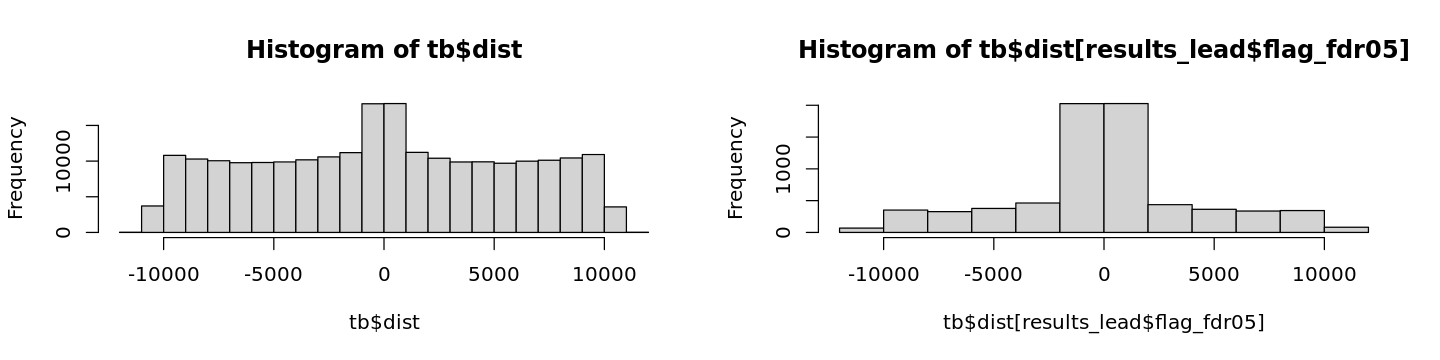

In [17]:
# This maps one cell type, so need to redo picking top choices or for all #run1
options(repr.plot.width=12, repr.plot.height=3)
par(mfrow=c(1,2))
hist(tb$dist, breaks=22)
hist(tb$dist[results_lead$flag_fdr05], breaks=12)

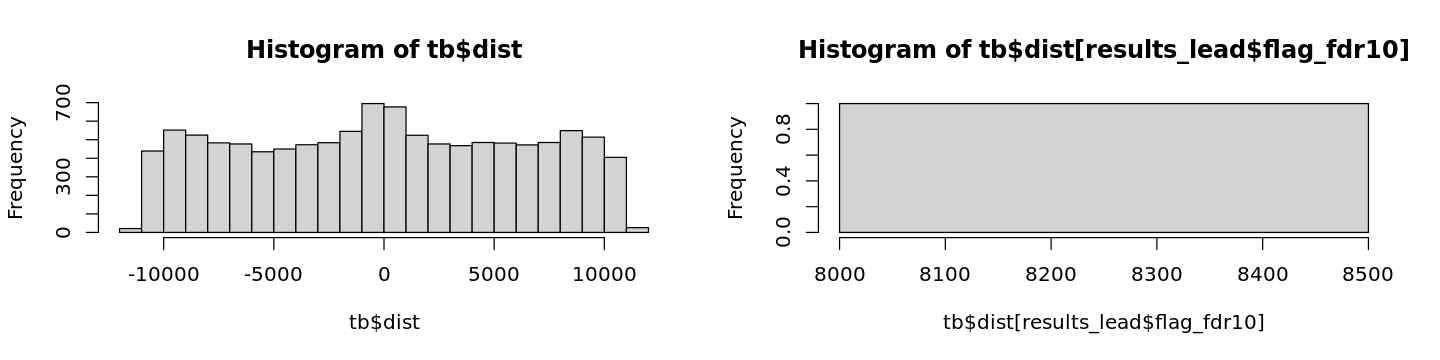

In [24]:
## This maps one cell type, so need to redo picking top choices or for all # run12
#options(repr.plot.width=12, repr.plot.height=3)
#par(mfrow=c(1,2))
#hist(tb$dist, breaks=22)
#hist(tb$dist[results_lead$flag_fdr10], breaks=12)

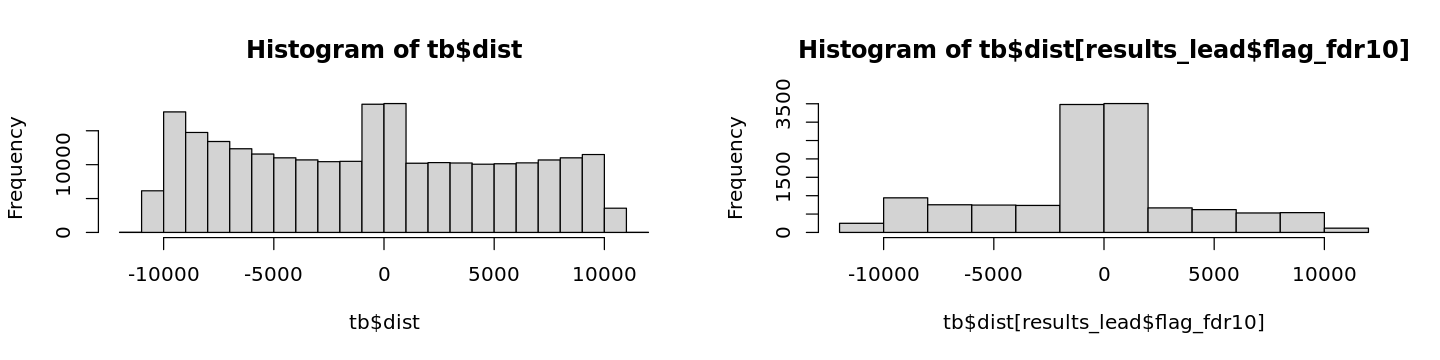

In [18]:
# This maps one cell type, so need to redo picking top choices or for all
#options(repr.plot.width=12, repr.plot.height=3)
#par(mfrow=c(1,2))
#hist(tb$dist, breaks=22)
#hist(tb$dist[results_lead$flag_fdr10], breaks=12) #Run7

In [51]:
sum(results_lead$flag_fdr10) #run1

[1] 2

In [25]:
#sum(results_lead$flag_fdr10) #run11

[1] 1

In [19]:
#sum(results_lead$flag_fdr10) #run7

[1] 12882

In [35]:
#bed = str_split_fixed(results_lead$Feature, ":|-", 3)
#mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)
#tb = data.frame(midpoint = round(mid), snppsos = results_lead$position)
#tb$dist = tb$snppsos - tb$midpoint

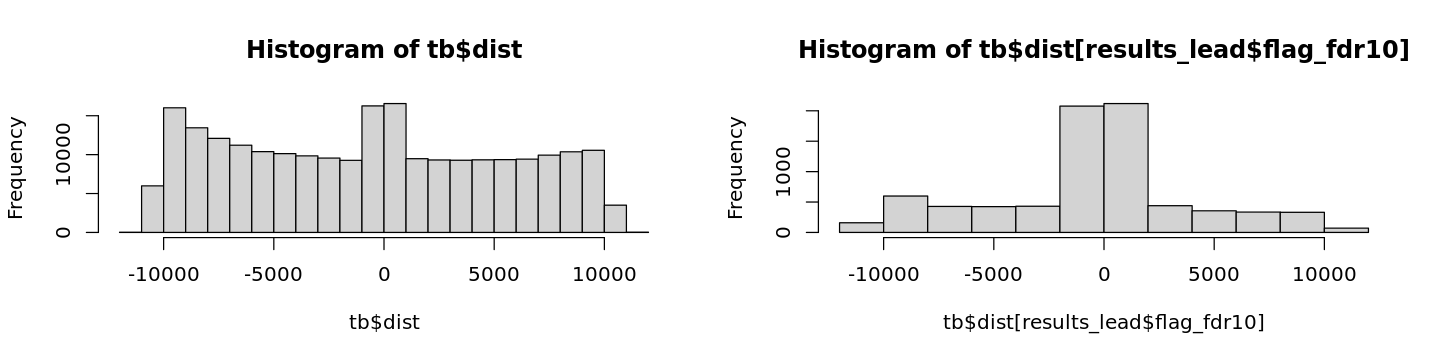

In [36]:
## This maps one cell type, so need to redo picking top choices or for all
#options(repr.plot.width=12, repr.plot.height=3)
#par(mfrow=c(1,2))
#hist(tb$dist, breaks=22)
#hist(tb$dist[results_lead$flag_fdr10], breaks=12)

In [26]:
#sum(results_lead$flag_fdr10)

[1] 7

In [19]:
#bed = str_split_fixed(results_lead$Feature, ":|-", 3)
#mid = as.numeric(bed[,2]) + ((as.numeric(bed[,3])-as.numeric(bed[,2]))/2)
#tb = data.frame(midpoint = round(mid), snppsos = results_lead$position)
#tb$dist = tb$snppsos - tb$midpoint

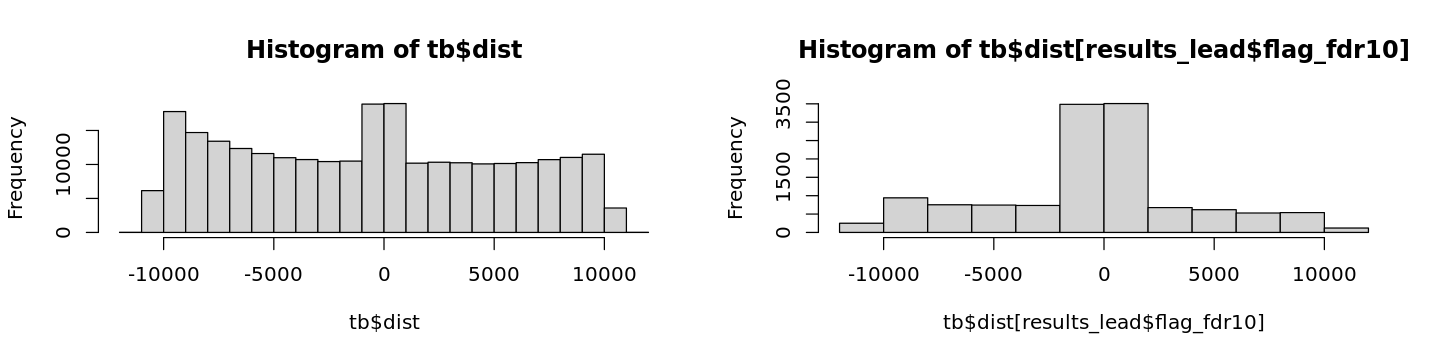

In [20]:
## This maps one cell type, so need to redo picking top choices or for all
#options(repr.plot.width=12, repr.plot.height=3)
#par(mfrow=c(1,2))
#hist(tb$dist, breaks=22)
#hist(tb$dist[results_lead$flag_fdr10], breaks=12)

In [21]:
#sum(results_lead$flag_fdr10)

[1] 12901